# Functional Encryption - Classification and information leakage


## Purpose

We proceed like part 3 except we put a public network over the private output not only for the collateral task but also for main one.

Actually, we also provide more epochs for the main task to train as this training is fast and more epochs are required when the model gets deeper. The model isn't deeper for the collateral task so we don't have to increase the number of epochs there.

Moreover, we provide a new parameter `PRIVATE_OUTPUT_SIZE = 10` which controls the size of the private output, as this doesn't need anymore to be 10 for we have another public network on top of it.


# 4 Tempering Collateral Learning


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import learn
from learn import show_results
# We now import from the collateral module
from learn import collateral

## 4.1 Simultaneous training

We will do the training in a single phase, as the collateral phase does not interfere with the main one.

We have reduced the collateral network size, it now just a simple FFN, to keep computation fast. We'll get back to CNN later don't worry!

The way the procedure is handled is the following: we alternate epochs, one on the main task which updates the quadratic and the character part of the network, and one on the collateral task which only updates the font family part of the network.

Therefore, if we call `Q` the quadratic part, `C` the net on top of `Q` used to predict characters and `F` the net for predicting families, the global network will be structured as follows:
```
  |
  Q
 / \
C   F
|   |
```

We will do a 2-phase process:
 - `Optimize: Q + C`
 - `Optimize: Freezed(Q) + F`

In [3]:
PRIVATE_OUTPUT_SIZE = 10
N_CHARS = 10
N_FONTS = 2

class Parser:
    def __init__(self):
        self.epochs = 10
        self.lr = 0.0006
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300

class CollateralNet(nn.Module):
    def __init__(self):
        super(CollateralNet, self).__init__()
        self.proj1 = nn.Linear(784, 40)
        self.diag1 = nn.Linear(40, PRIVATE_OUTPUT_SIZE, bias=False)

        # --- FFN for characters
        self.lin1 = nn.Linear(PRIVATE_OUTPUT_SIZE, 32)
        self.lin2 = nn.Linear(32, N_CHARS)

        # --- FFN for families
        self.lin3 = nn.Linear(PRIVATE_OUTPUT_SIZE, 32)
        self.lin4 = nn.Linear(32, N_FONTS)

    def quad(self, x):
        # --- Quadratic
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

    def char_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def font_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin3(x))
        x = self.lin4(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.char_net(x)
        return F.log_softmax(x, dim=1)

    def forward_font(self, x):
        x = self.quad(x)
        x = self.font_net(x)
        return F.log_softmax(x, dim=1)
    
    # We add the ability to freeze some layers to ensure that the collateral task does
    # not modify the quadratic net
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.lin3, self.lin4]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params

    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False

    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
    
    

In [4]:
def dual_learning_phase(model):
    """
    Perform a dual learning phase
    """
    args = Parser()
    
    train_loader, test_loader = collateral.get_data_loaders(args)

    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + 1):
        collateral.train(args, model, train_loader, optimizer, epoch, 0, True, False, False)
        test_perf_char, test_perf_font = collateral.test(args, model, test_loader, False)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [5]:
results = {}

In [6]:
model = CollateralNet()
test_perfs_char_perturbate, test_perfs_font_perturbate = dual_learning_phase(model)
results[f"Main task with output size {PRIVATE_OUTPUT_SIZE}"] = test_perfs_char_perturbate
results[f"Collateral task with output size {PRIVATE_OUTPUT_SIZE}"] = test_perfs_font_perturbate

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.313323 Loss Font: 0.683057
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.201125 Loss Font: 0.585809
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.132506 Loss Font: 0.537199
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.066628 Loss Font: 0.574511

Test set: Accuracy Char : 9726/10000 (97.26%)
          Accuracy Font : 7685/10000 (76.85%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.189853 Loss Font: 0.508103
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.093718 Loss Font: 0.531703
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.127319 Loss Font: 0.360883
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.004285 Loss Font: 0.375484

Test set: Accuracy Char : 9744/10000 (97.44%)
          Accuracy Font : 7667/10000 (76.67%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.097861 Loss Font: 0.520249
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.005711 Loss Font: 0.367483
Train Epoch: 3 [38400/60000 (

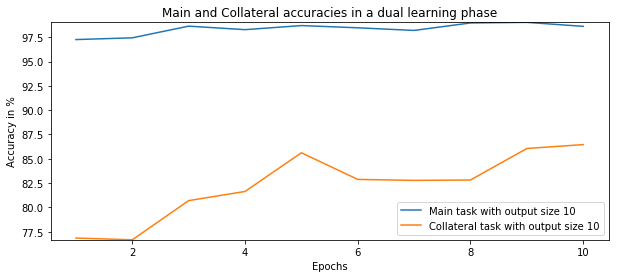

In [7]:
show_results(results, title="Main and Collateral accuracies in a dual learning phase")

As expected, the main task is not affected by our new process. As expected, the collateral network performs less well compared to Part 3 which is also expected as it is way smaller, but still achieves >82% accuracy. We'll do the test with the CNN at the end of this tutorial to make sure we can infer results on CNN looking at smaller networks which are faster to train.

## 4.2 Reducing the private output size


We now change the output of the private network to see how the main and collateral accuracy degrade.

In [8]:
for PRIVATE_OUTPUT_SIZE in [8, 7, 6, 5, 4, 3, 2]:
    print('\n -----', PRIVATE_OUTPUT_SIZE)
    model = CollateralNet()
    test_perfs_char_perturbate, test_perfs_font_perturbate = dual_learning_phase(model)
    results[f"Main task with output size {PRIVATE_OUTPUT_SIZE}"] = test_perfs_char_perturbate
    results[f"Collateral task with output size {PRIVATE_OUTPUT_SIZE}"] = test_perfs_font_perturbate


 ----- 8
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.288626 Loss Font: 0.694739
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.200182 Loss Font: 0.687527
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.077880 Loss Font: 0.646232
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.078429 Loss Font: 0.596583

Test set: Accuracy Char : 9761/10000 (97.61%)
          Accuracy Font : 6862/10000 (68.62%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.050008 Loss Font: 0.550224
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.056744 Loss Font: 0.470694
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.014799 Loss Font: 0.460430
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.027009 Loss Font: 0.437807

Test set: Accuracy Char : 9751/10000 (97.51%)
          Accuracy Font : 7438/10000 (74.38%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.089593 Loss Font: 0.495279
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.012582 Loss Font: 0.451468
Train Epoch: 3 [384

Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.180836 Loss Font: 0.593560
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.066138 Loss Font: 0.539529
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.116637 Loss Font: 0.647699

Test set: Accuracy Char : 9685/10000 (96.85%)
          Accuracy Font : 6595/10000 (65.95%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.047824 Loss Font: 0.604901
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.115033 Loss Font: 0.685480
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.013761 Loss Font: 0.672908
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.110009 Loss Font: 0.567075

Test set: Accuracy Char : 9618/10000 (96.18%)
          Accuracy Font : 6486/10000 (64.86%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.004901 Loss Font: 0.552419
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.032921 Loss Font: 0.633113
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.025426 Loss Font: 0.555507
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.073506 Loss Font: 0.749125

Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.117505 Loss Font: 0.532931
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.036218 Loss Font: 0.607384
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.033380 Loss Font: 0.587571

Test set: Accuracy Char : 9776/10000 (97.76%)
          Accuracy Font : 6805/10000 (68.05%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.076263 Loss Font: 0.571340
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.070313 Loss Font: 0.697019
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.023401 Loss Font: 0.617856
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.129122 Loss Font: 0.599682

Test set: Accuracy Char : 9827/10000 (98.27%)
          Accuracy Font : 6784/10000 (67.84%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.061292 Loss Font: 0.666932
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.025005 Loss Font: 0.596591
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.002943 Loss Font: 0.617623
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.148178 Loss Font: 0.578132

Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.278454 Loss Font: 0.643921
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.301453 Loss Font: 0.665710
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.370109 Loss Font: 0.612121

Test set: Accuracy Char : 8496/10000 (84.96%)
          Accuracy Font : 5654/10000 (56.54%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.288005 Loss Font: 0.640946
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.243830 Loss Font: 0.693191
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.222028 Loss Font: 0.678489
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.512994 Loss Font: 0.606843

Test set: Accuracy Char : 9091/10000 (90.91%)
          Accuracy Font : 5558/10000 (55.58%)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.184116 Loss Font: 0.636054
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.692189 Loss Font: 0.680086
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.477685 Loss Font: 0.734304
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.124082 Loss Font: 0.621062

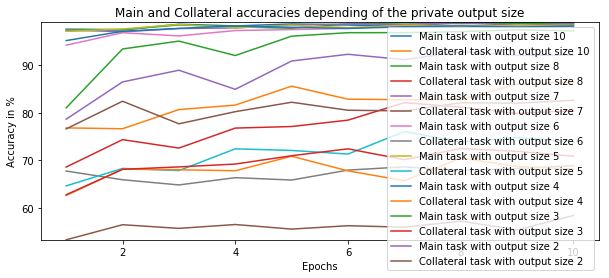

In [9]:
show_results(results, title="Main and Collateral accuracies depending of the private output size")


Let's zoom on the main accuracy

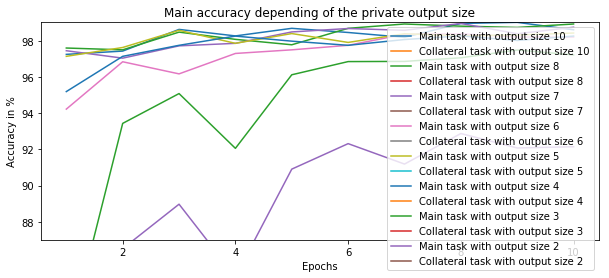

In [17]:
main_results = {k:v for k, v in results.items() if 'Main' in k}
show_results(main_results, title="Main accuracy depending of the private output size", ymin=87)

And the collateral one, even if it is not very readable

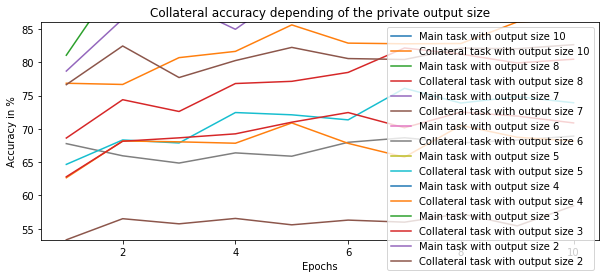

In [11]:
collateral_results = {k:v for k, v in results.items() if 'Collateral' in k}
show_results(collateral_results, title="Collateral accuracy depending of the private output size", ymax=86)

What we observe here is interesting, the main task does not present significant weakness until we get at size 3 where we drop to 97.5% which is still very good although 1% under the other accuracies. In return, the collateral accuracy starts significantly to decrease for output size 5, and keeps decreasing. At size 4, it is only 67% on average so 15% less than the baseline.

As a conclusion, depending on how crucial the main task is, we might keep an output size of 3 or 4.

## 4.3 When the collateral model is a CNN

We perform the same experiment but with the collateral model being a CNN, to see is we observ similar behaviours.

In [14]:
class CollateralNet(nn.Module):
    def __init__(self):
        super(CollateralNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, PRIVATE_OUTPUT_SIZE, bias=False)

        # --- FFN for characters
        self.lin1 = nn.Linear(PRIVATE_OUTPUT_SIZE, 32)
        self.lin2 = nn.Linear(32, N_CHARS)

        # --- Junction
        self.jct = nn.Linear(PRIVATE_OUTPUT_SIZE, 784)

        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)

    def quad(self, x):
        # --- Quadratic
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

    def char_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def font_net(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)

        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.char_net(x)
        return F.log_softmax(x, dim=1)

    def forward_font(self, x):
        x = self.quad(x)
        x = self.font_net(x)
        return F.log_softmax(x, dim=1)
    
    # We add the ability to freeze some layers to ensure that the collateral task does
    # not modify the quadratic net
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params

    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False

    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
    
    

In [15]:
cnn_results = {}
for PRIVATE_OUTPUT_SIZE in [7, 6, 5, 4, 3, 2]:
    print('\n -----', PRIVATE_OUTPUT_SIZE)
    model = CollateralNet()
    test_perfs_char_perturbate, test_perfs_font_perturbate = dual_learning_phase(model)
    cnn_results[f"Main task with output size {PRIVATE_OUTPUT_SIZE}"] = test_perfs_char_perturbate
    cnn_results[f"Collateral task withoutput size {PRIVATE_OUTPUT_SIZE}"] = test_perfs_font_perturbate


 ----- 7
Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 2.287353 Loss Font: 0.689093
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.094477 Loss Font: 0.436518
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.068467 Loss Font: 0.432846
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.017784 Loss Font: 0.254172

Test set: Accuracy Char : 9743/10000 (97.43%)
          Accuracy Font : 8676/10000 (86.76%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.035164 Loss Font: 0.304296
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.073755 Loss Font: 0.421990
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.015552 Loss Font: 0.272583
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.069110 Loss Font: 0.421340

Test set: Accuracy Char : 9798/10000 (97.98%)
          Accuracy Font : 8127/10000 (81.27%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.119848 Loss Font: 0.329126
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.087026 Loss Font: 0.284109
Train Epoch: 3 [384


Test set: Accuracy Char : 9683/10000 (96.83%)
          Accuracy Font : 7728/10000 (77.28%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.074377 Loss Font: 0.555889
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.031807 Loss Font: 0.535404
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.063670 Loss Font: 0.391731
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.004856 Loss Font: 0.455808

Test set: Accuracy Char : 9814/10000 (98.14%)
          Accuracy Font : 7770/10000 (77.70%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.040870 Loss Font: 0.387848
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.068705 Loss Font: 0.348971
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.009490 Loss Font: 0.515722
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.021886 Loss Font: 0.243902

Test set: Accuracy Char : 9835/10000 (98.35%)
          Accuracy Font : 7830/10000 (78.30%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.001522 Loss Font: 0.424617
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.055869 Loss F

Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.096628 Loss Font: 0.693148

Test set: Accuracy Char : 9649/10000 (96.49%)
          Accuracy Font : 4995/10000 (49.95%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.054096 Loss Font: 0.692829
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.048559 Loss Font: 0.692153
Train Epoch: 3 [38400/60000 (64%)]	Loss Char: 0.294516 Loss Font: 0.693201
Train Epoch: 3 [57600/60000 (96%)]	Loss Char: 0.031537 Loss Font: 0.692924

Test set: Accuracy Char : 9682/10000 (96.82%)
          Accuracy Font : 5005/10000 (50.05%)
Train Epoch: 4 [0/60000 (0%)]	Loss Char: 0.016561 Loss Font: 0.693163
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.110297 Loss Font: 0.693040
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.115716 Loss Font: 0.691906
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.306325 Loss Font: 0.693118

Test set: Accuracy Char : 9625/10000 (96.25%)
          Accuracy Font : 4995/10000 (49.95%)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.154822 Loss F

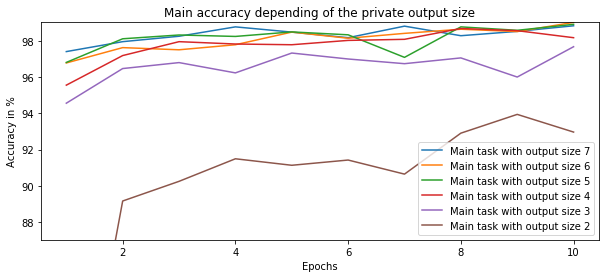

In [18]:
main_results = {k:v for k, v in cnn_results.items() if 'Main' in k}
show_results(main_results, title="Main accuracy depending of the private output size", ymin=87)

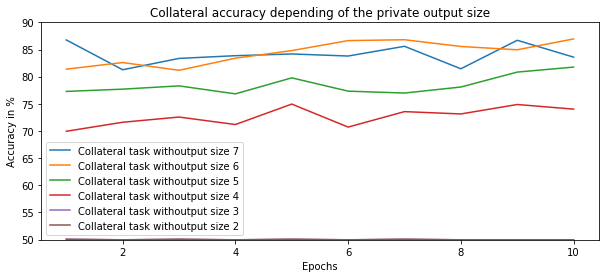

In [20]:
collateral_results = {k:v for k, v in cnn_results.items() if 'Collateral' in k}
show_results(collateral_results, title="Collateral accuracy depending of the private output size", ymax=90)

Down to output_size 4, we observe a similar decrease in accuracy down to 74%. However, for output size 2 & 3, the collateral CNN fails at learning anything, because the output is definitely too small compared to the learning rate. We could reduce the learning rate to have those results, but what we have already is convincing: we will keep an output size between 3 and 4 depending on our needs.

## Conclusion

What we observe here is that the private output size is a key factor to resist against collateral models. 

One interesting to notice also is that in Functional Encrytion, the execution time scales almost linearly with the the oupput size, so having a output size of 4 compared to 10 is great benefit!